# 5. Global wind interpolation with vector-valued manifold GP [incomplete]

In [1]:
import numpy as np
import jax.numpy as jnp
import tensorflow_probability
tfp = tensorflow_probability.experimental.substrates.jax
tfk = tfp.math.psd_kernels

import os
path_to_tex = '/Library/TeX/texbin/'
os.environ["PATH"] += os.pathsep + path_to_tex # Quick fix for matplotlib not detecting latex error https://stackoverflow.com/questions/54477891/filenotfounderror-errno-2-no-such-file-or-directory-latex-latex-python

import matplotlib.pyplot as plt
from riemannianvectorgp.gp import GaussianProcess
from riemannianvectorgp.manifold import EmbeddedS2
from riemannianvectorgp.kernel import (
    MaternCompactRiemannianManifoldKernel,
    ManifoldProjectionVectorKernel,
    ScaledKernel
)
from riemannianvectorgp.utils import GlobalRNG
from utils import rad2deg, set_gp_hyperparameters
from dataclasses import dataclass
import cartopy.crs as ccrs

In this final section of the tutorial, we look at our [most recent result](https://arxiv.org/pdf/2110.14423.pdf) (as of the day of the workshop) on GPs defined over vector fields on manifolds.
This is achieved by using a trick that allows us to induce Gaussian random vector fields on manifolds by utilising several copies of scalar-valued GPs on manifolds.

The method is illustrated below when the base manifold is the 2-sphere $\mathbb{S}^2$:

<img src="figs/projection_illustration.png" alt="drawing" width="600"/>

**In the figure:** A vector-valued GP $\boldsymbol{f} : \mathbb{S}^2 \rightarrow \mathbb{R}^3$ (centre) is first constructed by gluing together three copies of scalar-valued GPs $f_i : \mathbb{S}^2 \rightarrow \mathbb{R}, i = 1, 2, 3$ (left), which model the individual components of the vectors. However, since this still does not define a vector field, which requires the vectors to be tangential to the manifold, we project the vectors onto the tangent spaces of the sphere using a canonical projection operator given by the embedding map $\iota : \mathbb{S}^2 \xhookrightarrow{} \mathbb{R}^3$ (right).

The resulting object is not totally arbitrary - it really does produce a Gaussian random vector field in a certain sense (see Appendix).

We recreate the experiments in §4.2 of the paper where we interpolated artificial satellite observations of wind speed using the novel approach introduced in the paper.

In [2]:
rng = GlobalRNG(87824)

@dataclass
class params4plot:
    figsize: tuple = (5,5)
    # Properties for quiver plot
    scale: int = 150
    width: float = 0.006
    headwidth: int = 3
    alpha: float = 0.7
    color: str = "k"
    # Cartopy projection properties
    projection: ccrs.Projection = ccrs.Orthographic(150, 20)
    crs: ccrs.Projection = ccrs.RotatedPole(pole_longitude=180)


def plot_vector_field(
        params: params4plot,
        x: np.ndarray,
        y: np.ndarray,
        u: np.ndarray,
        v: np.ndarray,
        fig: plt.Figure = None,
        ax: plt.Axes = None
    ):
    
    if fig == None:
        fig = plt.figure(figsize=params.figsize)
    if ax == None:
        ax = plt.axes(projection=params.projection)
    ax.gridlines()
    ax.stock_img()
    ax.coastlines()
    ax.quiver(x, y, u, v,
              alpha=params.alpha,
              color=params.color,
              scale=params.scale,
              width=params.width,
              headwidth=params.headwidth,
              transform=params.crs)

    return (fig, ax)


For the data, we load a pre-processed version of the ERA-5 u and v components of windspeed at 10m above ground, regridded onto a 5.625° grid. For the training data, we generate artificial observations of the windspeed where the input variable $X$ are the (lat, lon)-values of the minutely positions of the satellite over 12 hours and the target variables $Y$ are the (u, v)-components of the windspeed anomaly along the satellite track. The windspeed anomaly was computed by subtracting the climatological wind speed (in this case weekly climatology) from the full wind speed.

In [16]:
# Load ground truth data for 10m u and v components of wind
u_ground_truth = np.load("data/10m_u_component_of_wind_5.625deg_2019_01_01.npy")
v_ground_truth = np.load("data/10m_v_component_of_wind_5.625deg_2019_01_01.npy")

# Load climatology (weekly mean windspeed)
climatology = np.load("data/climatological_windspeed.npz")
u_climatology, v_climatology = climatology["u"], climatology["v"]

# Load training data and testing locations
X_train = np.load("data/12hrs_aeolus_satellite_track_2019_01_01.npy")
full_windspeed = np.load("data/windspeed_along_12hrs_aeolus_satellite_track_2019_01_01.npy")
windspeed_anomaly = np.load("data/windspeed_anomaly_along_12hrs_aeolus_satellite_track_2019_01_01.npy")
Y_train = windspeed_anomaly

# Load query points (these are just points on a 5.625° grid)
test_locs = np.load("data/test_locations_5.625deg_mesh.npz")
lon, lat = test_locs['lon'], test_locs['lat']
X_query = np.stack([lat, lon], axis=1)


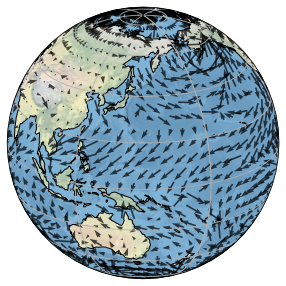

In [15]:
# Plot ground truth wind field
lon_deg = rad2deg(lon).reshape(32, 64)
lat_deg = rad2deg(lat, offset=jnp.pi/2).reshape(32, 64)

plotparams = params4plot(scale=170)
_, _ = plot_vector_field(plotparams, lon_deg, lat_deg, u_ground_truth, v_ground_truth)

plt.savefig("figs/ground_truth_vector_field.png", dpi=200)


We again use our package `riemannianvectorgp` ([link to the repository](https://github.com/MJHutchinson/ExtrinsicGaugeIndependentVectorGPs)) to set up our GP, which is tailored for constructing vector-valued GPs on manifolds.

In [17]:
# Setting up a vector-valued manifold GP is super easy
S2 = EmbeddedS2(1.0)
kernel = ScaledKernel( # We add the variance hyperparameter by wraping with ScaledKernel
    ManifoldProjectionVectorKernel( # Just need to wrap a manifold kernel with a ManifoldProjectionVectorKernel to make it into a vector-valued GP!
        MaternCompactRiemannianManifoldKernel(smoothness=3/2,
                                              compact_riemannian_manifold=S2,
                                              truncation=144  # 144 is the maximum number of basis functions we have implemented
                                              ),
                                              manifold=S2
    )
)

gp = GaussianProcess(kernel)

In [18]:
# Set the lengthscale and amplitude with the same values as in our paper
params, state = set_gp_hyperparameters(next(rng), gp, kernel, lengthscale=jnp.exp(-1.522926), amplitude=jnp.exp(9.7))

Conditioning and predicting is done in the same way as in the scalar-valued manifold GP.

In [19]:
# Condition vector-valued manifold GP on windspeed anomaly data
noise_std = 1.
noises = jnp.ones_like(Y_train) * noise_std**2

state = gp.condition(params, X_train, Y_train, noises)

In [20]:
# Prediction
mean, cov = gp(params, state, X_query)

The GP only predicts the windspeed anomaly with respect to the weekly climatology as that is what it was trained on, so we tack on the weekly climatology to the GP predicted values when we make the plots. One can also think of this as a GP with the prior mean set to the weekly climatology.

Text(0.5, 1.0, 'Posterior mean')

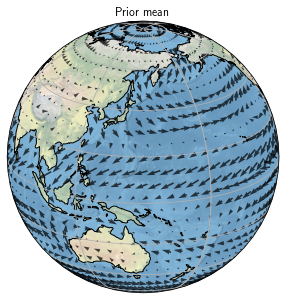

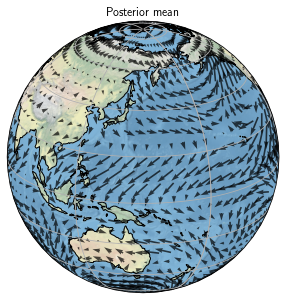

In [21]:
# Plot results
u_predict = mean[:,1] + u_climatology.flatten() # Add climatology data (prior mean) to recover full wind field
v_predict = mean[:,0] + v_climatology.flatten()

x_train_deg = rad2deg(X_train[:,1])
y_train_deg = rad2deg(X_train[:,0], offset=jnp.pi/2)
x_query_deg = rad2deg(X_query[:,1])
y_query_deg = rad2deg(X_query[:,0], offset=jnp.pi/2)

# Plot climatology
plotparams = params4plot(scale=150)
_, _ = plot_vector_field(plotparams, x_query_deg, y_query_deg, u_climatology.flatten(), v_climatology.flatten())
plt.savefig("figs/prior_mean_vector_field.png", dpi=200)
plt.title("Prior mean")

# Plot prediction
_, ax = plot_vector_field(plotparams, x_query_deg, y_query_deg, u_predict, v_predict)
plt.savefig("figs/posterior_mean_vector_field.png", dpi=200)
plt.title("Posterior mean")


We also plot the uncertainty bars of the GP prediction below given only the first hour of training data.

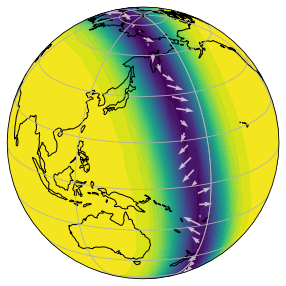

In [22]:
# Plot uncertainty using only one hour of data
i = 0
Y = Y_train[i*60:(i+1)*60]
X = X_train[i*60:(i+1)*60]
x_deg = rad2deg(X[:,1])
y_deg = rad2deg(X[:,0], offset=jnp.pi/2)

noises = jnp.ones_like(Y) * noise_std**2
state = gp.condition(params, X, Y, noises)
mean, cov = gp(params, state, X_query)
var = jnp.diag(jnp.trace(cov, axis1=2, axis2=3))

_, ax = plot_vector_field(plotparams, x_query_deg, y_query_deg, u_predict, v_predict)
ax.contourf(x_query_deg.reshape(32, 64), y_query_deg.reshape(32, 64), var.reshape(32, 64), levels=30, transform=plotparams.crs, cmap='viridis')
ax.quiver(x_deg[i*60:], y_deg[i*60:], full_windspeed[i*60:(i+1)*60,1], full_windspeed[i*60:(i+1)*60,0],
            alpha=plotparams.alpha,
            color='w',
            scale=plotparams.scale,
            width=plotparams.width,
            headwidth=plotparams.headwidth,
            zorder=2,
            transform=plotparams.crs)

plt.savefig("figs/vector_field_uncertainty.png", dpi=200)

As expected, our GP predicts uncertainty regions that are compatible with the locations of the satellite observations (in white) and the geometry of the sphere.

## Create animation for talk

In [12]:
from celluloid import Camera

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11


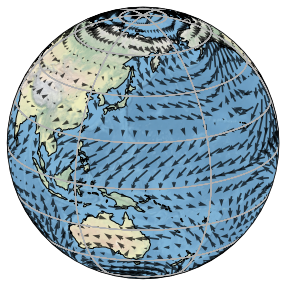

In [13]:
fig = plt.figure(figsize=(5, 5))
camera = Camera(fig)

plotparams = params4plot(scale=150)
ax = plt.axes(projection=plotparams.projection)
u, v = u_climatology.flatten(), v_climatology.flatten()
fig, ax = plot_vector_field(plotparams, x_query_deg, y_query_deg, u, v, fig, ax)
camera.snap()
for i in range(12):
    print(f"Iteration: {i}")
    Y = Y_train[:(i+1)*60]
    X = X_train[:(i+1)*60]
    x_deg = rad2deg(X[:,1])
    y_deg = rad2deg(X[:,0], offset=jnp.pi/2)

    noises = jnp.ones_like(Y) * noise_std**2
    state = gp.condition(params, X, Y, noises)
    mean, cov = gp(params, state, X_query)
    u = mean[:,1] + u_climatology.flatten()
    v = mean[:,0] + v_climatology.flatten()

    fig, ax = plot_vector_field(plotparams, x_query_deg, y_query_deg, u, v, fig, ax)
    ax.quiver(x_deg[i*60:], y_deg[i*60:], full_windspeed[i*60:(i+1)*60,1], full_windspeed[i*60:(i+1)*60,0],
            alpha=plotparams.alpha,
            color='r',
            scale=plotparams.scale,
            width=plotparams.width,
            headwidth=plotparams.headwidth,
            zorder=2,
            transform=plotparams.crs)
    camera.snap()

fig, ax = plot_vector_field(plotparams, x_query_deg, y_query_deg, u, v, fig, ax)
camera.snap()

animation = camera.animate(interval=100, repeat=False)
animation.save("figs/vector_gp_conditioning.gif", dpi=200)